 DAEDALUS – Distributed and Automated Evolutionary Deep Architecture Learning with Unprecedented Scalability

This research code was developed as part of the research programme Open Technology Programme with project number 18373, which was financed by the Dutch Research Council (NWO), Elekta, and Ortec Logiqcare.

Project leaders: Peter A.N. Bosman, Tanja Alderliesten
Researchers: Alex Chebykin, Arthur Guijt, Vangelis Kostoulas
Main code developer: Arthur Guijt

In [1]:
import pandas as pd

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(ggplot2)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
date_of_processing = "2023-02-09"

In [4]:
def process_trace(path, tag):
    df = pd.read_json(path, lines=True).sort_values(["t", "ord", "kind"])
    # Turn trace into processor assignments
    procs = []
    nprocs = 0
    def get_proc():
        nonlocal procs, nprocs
        if len(procs) > 0:
            return procs.pop()
        else:
            nprocs += 1
            return nprocs - 1
    ord_to_proc = {}
    df["proc"] = None
    for (idx, l) in df.iterrows():
        if l["kind"] == "new":
            p = get_proc()
            df.loc[idx, "proc"] = p
            ord_to_proc[l["ord"]] = p
        else:
            p = ord_to_proc[l["ord"]]
            procs.append(p)
    # Find spans
    df = pd.merge(df.loc[df["kind"] == "new", ["ord", "t", "proc"]], df.loc[df["kind"] == "performed", ["ord", "t"]], on=["ord"], suffixes=("_start", "_end"))
    df["tag"] = tag
    return df

popsize = 8
data = pd.concat([
    process_trace(f"./results/traced-run-example-a6f16f2/trap_bisect_2/{popsize}/events.jsonl", "synchronous"),
    process_trace(f"./results/traced-run-example-a6f16f2/trap_bisect_3/{popsize}/events.jsonl", "asynchronous")
])

In [5]:
data

,ord,t_start,proc,t_end,tag
0,0,0.00,0,42.58,synchronous
1,1,0.00,1,46.54,synchronous
2,2,0.00,2,52.48,synchronous
3,3,0.00,3,52.48,synchronous
4,4,0.00,4,52.48,synchronous
...,...,...,...,...,...
475,478,720.02,2,720.02,asynchronous
476,480,720.04,7,720.04,asynchronous
477,482,724.00,1,724.00,asynchronous
478,484,724.98,4,724.98,asynchronous


In [51]:
%%R -i data
t_ends <- data |> filter(`t_end` <= 130) |> group_by(`tag`) |> summarise(t_end_max = max(`t_end`))

# forcibly align leftovers?
# data_mod <- data <- data |> merge(t_ends, on=`tag`) |> head()
data_mod <- data <- data |> merge(t_ends, on=`tag`) |> mutate(
    t_end=ifelse(`t_start` < `t_end_max`, ifelse(`t_end` < `t_end_max`, `t_end`, `t_end_max`), `t_end`)
) |> head()
data_mod

           tag ord t_start proc t_end t_end_max
1 asynchronous   0       0    0 42.58    114.86
2 asynchronous   1       0    1 46.54    114.86
3 asynchronous   2       0    2 52.48    114.86
4 asynchronous   3       0    3 52.48    114.86
5 asynchronous   4       0    4 52.48    114.86
6 asynchronous   5       0    5 34.66    114.86


Saving 4.86 x 2.78 in image
Saving 4.86 x 2.78 in image


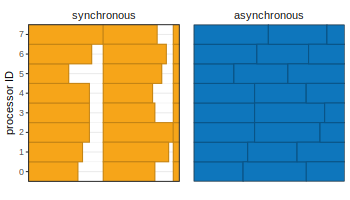

In [59]:
%%R -i data -i date_of_processing -w 350 -h 200
barheight = 1.0
maxprocs = max(data$proc)

plt0 <- data |>
    mutate(
        tag = factor(`tag`, levels=c('synchronous', 'asynchronous')),
        ymin = `proc` - barheight / 2,
        ymax = `proc` + barheight / 2
    ) |> 
    ggplot(aes(xmin=`t_start`, xmax=`t_end`, ymin=`ymin`, ymax=`ymax`, fill=`tag`), color='black') +
    geom_rect(aes(color=`tag`)) +
    scale_fill_manual(values=c("synchronous"="#f6a519", "asynchronous"="#0e76bc")) +
    scale_color_manual(values=c("synchronous"="#c48414", "asynchronous"="#095487")) +
    coord_cartesian(xlim = c(0, 130)) +
    scale_x_continuous(breaks=NULL, limits=c(0, 500), expand=c(0.0, 0.0)) +
    scale_y_continuous(breaks=seq.int(0, maxprocs), expand=c((1-barheight)/maxprocs, (1-barheight)/maxprocs)) +
    facet_grid(. ~ tag) +
    guides(fill = NULL) +
    theme_bw() +
    theme(
      legend.position = "none",
      panel.spacing = unit(1, "lines"),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank(),
      strip.text.x = element_text(size = 11)) +
    labs(x="", y="processor ID")

fpath = paste(date_of_processing, "-sync-vs-async.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-sync-vs-async.png", sep="")
ggsave(fpath, type = "cairo")

plt0

Saving 4.86 x 2.78 in image
Saving 4.86 x 2.78 in image


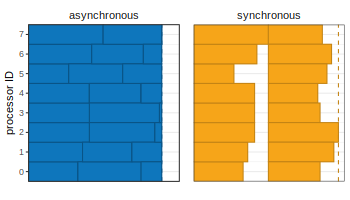

In [60]:
%%R -i data -i date_of_processing -w 350 -h 200
barheight = 1.0
maxprocs = max(data$proc)

t_ends <- data |> filter(`t_end` <= 130) |> group_by(`tag`) |> summarise(t_end_max = max(`t_end`))

# forcibly align leftovers.
data_mod <- data <- data |> merge(t_ends, on=`tag`) |> mutate(
    t_end=ifelse(`t_start` < `t_end_max`, ifelse(`t_end` < `t_end_max`, `t_end`, `t_end_max`), `t_end`)
)

plt1 <- data_mod |>
    mutate(
        tag = factor(`tag`, levels=c('synchronous', 'asynchronous')),
        ymin = `proc` - barheight / 2,
        ymax = `proc` + barheight / 2
    ) |> 
    ggplot(aes(xmin=`t_start`, xmax=`t_end`, ymin=`ymin`, ymax=`ymax`, fill=`tag`), color='black') +
    geom_rect(aes(color=`tag`)) +
    geom_vline(data=t_ends, linetype="dashed", aes(xintercept=`t_end_max`, color=`tag`)) +
    scale_fill_manual(values=c("synchronous"="#f6a519", "asynchronous"="#0e76bc")) +
    scale_color_manual(values=c("synchronous"="#c48414", "asynchronous"="#095487")) +
    coord_cartesian(xlim = c(0, 130)) +
    scale_x_continuous(breaks=NULL, limits=c(0, 130), expand=c(0.0, 0.0)) +
    scale_y_continuous(breaks=seq.int(0, maxprocs), expand=c((1-barheight)/maxprocs, (1-barheight)/maxprocs)) +
    facet_grid(. ~ tag) +
    guides(fill = NULL) +
    theme_bw() +
    theme(
      legend.position = "none",
      panel.spacing = unit(1, "lines"),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank(),
      strip.text.x = element_text(size = 11)) +
    labs(x="", y="processor ID")

fpath = paste(date_of_processing, "-sync-vs-async-mod.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-sync-vs-async-mod.png", sep="")
ggsave(fpath, type = "cairo")

plt1